# 📈 **GRAPHS ALGORITHMS GENERATOR** 

---------------------------
### **IMPORTS**

In [231]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from math import floor, ceil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from copy import deepcopy

import time
import os
import sys
from pathlib import Path

#Fallaba por la barra al final
src_path = Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent
sys.path.append(str(src_path)  + os.sep)

src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append( (src_path + os.sep) )

from models.classifiers.CoForestClassifier import CoForest
from models.classifiers.TriTrainingClassifier import TriTraining
from models.classifiers.DemocraticCoClassifier import DemocraticCo
from models.classifiers.utils import *
from models.notebooks.graphs_utils import *

---------------------------
### **CLASSES**

Fit methods needs to be overwritten since graphs are generated while training, so inheritance is used.

In [232]:
class CoForest_graphs(CoForest):

    def fit(self, L, y, U, X_test, y_test, w_init_criteria='percentage_L', file_name="file.csv"):
        """
        Fits the ensemble using both labeled and
        pseudo-labeled data. Generates graphs to show 
        how score evolves during training.

        Parameters
        ----------
        L: np.array
            Labeled data used for training
        y: np.array
            Tags of the labeled data used for training
        U: np.array
            Unlabeled data used for training
        X_test: np.array
            samples to check evolution
        y_test: np.array
            labels of samples to check evolution
        """

        mask_L = self.create_trees(L, y)
        scores = [self.score(X_test, y_test)]

        e = [0 for i in range(self.n)]
        W = [0 for i in range(self.n)]

        previous_e = [0.5 for i in range(self.n)]
        previous_W = previous_W = self.initialize_previous_W(L, w_init_criteria)
        print("Method: {}. Previous W: {}".format(w_init_criteria, [ '%.2f' % elem for elem in previous_W ]))
        
        new_data = True
        t = 0

        while new_data:

            t += 1
            tree_changes = np.array([False for i in range(self.n)])
            tree_pseudo_updates = [() for i in range(self.n)]

            for i, hi in self.ensemble.items():

                e[i] = self.concomitant_oob_error(hi, L, y, mask_L)
                W[i] = previous_W[i]
                pseudo_labeled_data = []
                pseudo_labeled_tags = []

                if e[i] < previous_e[i]:

                    if e[i] == 0:
                        Wmax = self.theta * U.shape[0]
                    else:
                        Wmax = min(
                            self.theta * U.shape[0], ((previous_e[i]*previous_W[i])/e[i]))

                    U_subsampled = self.subsample(hi, U, Wmax)
                    W[i] = 0

                    for u in U_subsampled:
                        concomitant_confidence, selected_class = self.concomitant_confidence(
                            hi, U[u, :])

                        if concomitant_confidence > self.theta:
                            tree_changes[i] = True
                            pseudo_labeled_data.append(U[u, :])
                            pseudo_labeled_tags.append(selected_class)
                            W[i] += concomitant_confidence

                tree_pseudo_updates[i] = (
                    (np.array(pseudo_labeled_data), np.array(pseudo_labeled_tags)))

            for i in np.fromiter(self.ensemble.keys(), dtype=int)[tree_changes]:
                if e[i] * W[i] < previous_e[i] * previous_W[i]:
                    self.retrain_tree(
                        i, L, y, tree_pseudo_updates[i][0], tree_pseudo_updates[i][1], mask_L)

            previous_e = deepcopy(e)
            previous_W = deepcopy(W)

            if tree_changes.sum() == 0:
                new_data = False

            scores.append(self.score(X_test, y_test))

        append_to_csv(file_name, scores)


In [233]:
class TriTraining_graphs(TriTraining):

    def fit(self, L, y, U, X_test, y_test):
        """
        Trains the tri-training ensemble using Zhi-Hua Zhou
        Algorithm. Generates graphs to show how score
        evolves during training.

        Parameters
        ----------
        L: np.array
            Labeled data used for training
        y: np.array
            Labeled data tags used for training
        U: np.array
            Unlabeled data used for training
        X_test: np.array
            samples to check evolution
        y_test: np.array
            labels of samples to check evolution
        """

        self.initialize_classifiers(L, y)
        self.classes = np.unique(y)

        previous_e = [0.5 for i in range(self.n)]
        previous_l = [0.0 for i in range(self.n)]
        e = [0.0 for i in range(self.n)]
        new_data = True

        t = 0
        scores = [self.score(X_test, y_test)]

        while new_data:

            t += 1
            cls_changes = np.array([False for i in range(self.n)])
            cls_pseudo_updates = [() for i in range(self.n)]

            for i in range(self.n):

                e[i] = self.measure_error(i, L, y)

                if e[i] < previous_e[i]:
                    cls_pseudo_updates[i] = self.create_pseudolabeled_set(i, U)

                    if previous_l[i] == 0:
                        previous_l[i] = floor(
                            (e[i] / (previous_e[i]-e[i])) + 1)

                    L_i_size = cls_pseudo_updates[i][0].shape[0]

                    if previous_l[i] < L_i_size:

                        if e[i] * L_i_size < previous_e[i] * previous_l[i]:
                            cls_changes[i] = True

                        elif previous_l[i] > (e[i] / (previous_e[i] - e[i])):

                            L_index = self.rd.choice(L_i_size, ceil(
                                (previous_e[i] * previous_l[i] / e[i]) - 1))
                            cls_pseudo_updates[i] = (
                                cls_pseudo_updates[i][0][L_index, :], cls_pseudo_updates[i][1][L_index])
                            cls_changes[i] = True

            if cls_changes.sum() == 0:
                new_data = False

            else:

                for i in np.fromiter(self.classifiers.keys(), dtype=int)[cls_changes]:

                    X_train = np.concatenate((L, cls_pseudo_updates[i][0]))
                    y_train = np.concatenate((y, cls_pseudo_updates[i][1]))
                    self.classifiers[i] = self.classifiers[i].fit(
                        X_train, y_train)

                    previous_e[i] = e[i]
                    # Tamaño de Li anterior
                    previous_l[i] = cls_pseudo_updates[i][0].shape[0]

                scores.append(self.score(X_test, y_test))

        append_to_csv("file.csv", scores)


In [234]:
class DemocraticCo_graphs(DemocraticCo):

    def fit(self, L, y, U, X_test, y_test):
        """
        Trains the democratic-Co.

        Parameters
        ----------
        L: np.array
            Labeled data used for training
        y: np.array
            Labeled data tags used for training
        U: np.array
            Unlabeled data used for training
        X_test: np.array
            samples to check evolution
        y_test: np.array
            labels of samples to check evolution
        """
        classes = np.unique(y)
        self.classes = classes
        changes = True

        e = [0] * self.n
        L_ = [(list(L), list(y)) for i in range(self.n)]
        U_in_L_ = [dict() for i in range(self.n)]
        cls_changes = np.ones(self.n, dtype=bool)

        t = 0
        scores = []

        while changes:

            for i in np.arange(self.n)[cls_changes]:
                self.classifiers[i] = self.classifiers[i].fit(*L_[i])
            cls_changes = np.zeros(self.n, dtype=bool)

            U_tag_votes = [{i: set() for i in self.classes} for x in U]
            U_y = []

            for x_id, x in enumerate(U):
                for id_cls, cls in self.classifiers.items():
                    prediction = cls.predict([x])[0]
                    U_tag_votes[x_id][prediction].add(id_cls)

                U_y.append(
                    max(U_tag_votes[x_id], key=lambda k: len(U_tag_votes[x_id].get(k))))

            # Choose which exs to propose for labeling
            w = [self.get_w(cls, L, y) for cls in self.classifiers.values()]
            L_prime = [([], []) for i in range(self.n)]
            Li_prime_ids = [[] for i in range(self.n)]

            for x_id, x in enumerate(U):

                most_voted_tag = U_y[x_id]
                cls_agree_tag = U_tag_votes[x_id][most_voted_tag]

                exp_1 = 0
                for cls in cls_agree_tag:
                    exp_1 += w[cls]

                exp_2 = 0
                for tag in classes:
                    if tag != most_voted_tag:
                        weight_tag = 0
                        for cls in U_tag_votes[x_id][tag]:
                            weight_tag += w[cls]
                        exp_2 = max(exp_2, weight_tag)

                if exp_1 > exp_2:
                    for id_cls in (set(self.classifiers.keys()) - cls_agree_tag):
                        Li_prime, y_Li_prime = L_prime[id_cls]
                        Li_prime.append(x)
                        y_Li_prime.append(U_y[x_id])
                        Li_prime_ids[id_cls].append(x_id)

            # Estimate if adding this is better
            l_mean = 0
            for id_cls, cls in self.classifiers.items():
                l_mean += confidence_interval(cls,
                                              L_[id_cls][0], L_[id_cls][1])[0]
            l_mean /= self.n

            for i in range(self.n):

                Li, y_Li = L_[i]
                Li_prime, y_Li_prime = L_prime[i]
                Li_union_Li_prime = Li + Li_prime

                q_i = len(Li) * (1 - 2 * (e[i] / len(Li))) ** 2
                e_i_prime = (1 - l_mean) * len(Li_prime)
                q_i_prime = len(
                    Li_union_Li_prime) * (1 - (2*(e[i] + e_i_prime) / len(Li_union_Li_prime))) ** 2

                if q_i_prime > q_i:
                    cls_changes[i] = True
                    e[i] = e[i] + e_i_prime

                    for x_id, x, y_x in zip(Li_prime_ids[i], Li_prime, y_Li_prime):
                        if x_id in U_in_L_[i]:
                            index = U_in_L_[i][x_id]
                            y_Li[index] = y_x

                        else:
                            U_in_L_[i][x_id] = len(Li)
                            Li.append(x)
                            y_Li.append(y_x)

            if cls_changes.sum() == 0:
                changes = False
                self.w = [self.get_w(cls, L, y)
                          for cls in self.classifiers.values()]

            self.w = [self.get_w(cls, L, y) for cls in self.classifiers.values()]
            scores.append(self.score(X_test, y_test))
            t += 1

        append_to_csv("file.csv", scores)


In [235]:
def create_base_cls(algorithm, n=6, thetha=0.75, max_features='log2', base_cls=None, rd=np.random.RandomState(10)):

    if base_cls is None:
        base_cls = [DecisionTreeClassifier(), 
                    GaussianNB(),
                    KNeighborsClassifier(n_neighbors=3)]

    if algorithm == 'CF':
        return CoForest(n, thetha, max_features, random_state=rd)

    elif algorithm == 'CFG':
        return CoForest_graphs(n, thetha, max_features, random_state=rd)

    elif algorithm == 'TT':
        return TriTraining(base_cls[0], base_cls[1], base_cls[2], rd)

    elif algorithm == 'TTG':
        return TriTraining_graphs(base_cls[0], base_cls[1], base_cls[2], rd)

    elif algorithm == 'DC':
        return DemocraticCo(base_cls, rd)

    elif algorithm == 'DCG':
        return DemocraticCo_graphs(base_cls, rd)


----------------------------
# **GENERAL GRAPHS**

---------------------------------------------------
### **score - número de iteraciones (entrenamiento)**

In [236]:
def graph_score_iterations_train_mosaic(available, algorithm='CF', rd_number=5):

    fig, ax = plt.subplot_mosaic(
        "AAABBCC;AAADDEE", figsize=(10, 4.5), tight_layout=True)
    ax['A'].set_ylabel('accuracy')
    ax['A'].set_xlabel('iteraciones')

    fig_2, ax_2 = plt.subplot_mosaic(
        "AAAAAAA;AAAAAAA", figsize=(10, 4.5), tight_layout=True)
    ax_2['A'].set_ylabel('accuracy')
    ax_2['A'].set_xlabel('iteraciones')

    max_iterations = 0

    for dataset_info in available:

        open('file.csv', 'w').close()
        X, y = dataset_info[0]
        rd = np.random.RandomState(rd_number)
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            L_train, U_train, Ly_train, Uy_train = train_test_split(
                X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
            cls = create_base_cls(algorithm + 'G', n=20, rd=rd)
            # Test used to evaluate how score changes during training
            cls.fit(L_train, Ly_train, U_train, X_test, y_test)

        mean = np.mean(create_graph_matrix("file.csv"), axis=0)
        std = np.std(create_graph_matrix("file.csv"), axis=0)

        x_ticks = [i for i in range(len(mean))]
        ax['A'].plot(mean, color=dataset_info[3],
                     linewidth=1, label=dataset_info[1]) #'-o',
        ax_2['A'].plot(mean, color=dataset_info[3],
                     linewidth=1, label=dataset_info[1]) #'-o',

        ax_i = ax[dataset_info[2]]
        ax_i.set_ylim([0.7, 1.05])
        ax_i.set_ylabel('accuracy')
        ax_i.set_xlabel('iteraciones')
        ax_i.set_xticks(x_ticks)
        ax_i.errorbar(x_ticks, mean, yerr=[std, np.minimum(
            std, 1-mean)], color=dataset_info[3], linewidth=0.5, label=dataset_info[1]) #fmt='-o',
        max_iterations = max(max_iterations, len(x_ticks))
        
        if len(mean) > 9:
            ax_i.xaxis.set_major_locator(ticker.MaxNLocator(7))
        elif len(mean) > 99:
            ax_i.xaxis.set_major_locator(ticker.MaxNLocator(6))
        elif len(mean) > 999:
            ax_i.xaxis.set_major_locator(ticker.MaxNLocator(5))

        break

    ax['A'].set_xticks([i for i in range(max_iterations)])
    ax_2['A'].set_xticks([i for i in range(max_iterations)])

    if max_iterations > 9:
        ax['A'].xaxis.set_major_locator(ticker.MaxNLocator(10))
        ax_2['A'].xaxis.set_major_locator(ticker.MaxNLocator(20))
    elif max_iterations > 99:
        ax['A'].xaxis.set_major_locator(ticker.MaxNLocator(8))
        ax_2['A'].xaxis.set_major_locator(ticker.MaxNLocator(16))
    elif max_iterations > 999:
        ax['A'].xaxis.set_major_locator(ticker.MaxNLocator(7))
        ax_2['A'].xaxis.set_major_locator(ticker.MaxNLocator(14))

    fig.legend([di[1] for di in available], bbox_to_anchor=(
        0.5, 1.0), loc='lower center', ncol=4)

    fig_2.legend([di[1] for di in available], bbox_to_anchor=(
        0.5, 1.0), loc='lower center', ncol=4)

    plt.show()


------------------------------------------------
### **número elementos - tiempo entrenamiento**


In [237]:
def graph_number_elem_training_time(algorithm='CF', rd_number=10):

    fig, ax = plt.subplots()
    X, y = load_digits(return_X_y=True)

    instancias = []
    tiempos = []
    rd = np.random.RandomState(rd_number)

    for i in range(500, X.shape[0], 100):

        indexes = rd.choice(X.shape[0], replace=False, size=i)
        L_train, U_train, Ly_train, Uy_train = train_test_split(
            X[indexes], y[indexes], test_size=0.8, random_state=rd)

        cls = create_base_cls(algorithm, n=20, rd=rd)
        inicio = time.time()
        cls.fit(L_train, Ly_train, U_train)
        fin = time.time()
        instancias.append(i)
        tiempos.append((fin-inicio))

    ax.scatter(instancias, tiempos, color='r')

    model = LinearRegression()
    model.fit(np.array([[i] for i in instancias]), tiempos)
    x_new = np.linspace(425, X.shape[0], 100)
    y_new = model.predict(x_new[:, np.newaxis])

    #plt.title("Instancias - Tiempo entrenamiento")
    ax.set_ylim(bottom=0)
    ax.plot(x_new, y_new, '--k')
    ax.set_xlabel('instancias')
    ax.set_ylabel('tiempo (s)')
    plt.show()


---------------------------------------------------
### **score - % instancias entrenamiento**

In [238]:
def score_percentage_training_instances(available, algorithm='CF', rd_number=5, n_experiments=10):

    fig, ax = plt.subplots()
    rd = np.random.RandomState(rd_number)

    for dataset_info in available:

        matriz_scores = []
        X, y = dataset_info[0]

        for j in range(n_experiments):
            scores_experimento = []

            for i in np.arange(0.5, 1, 0.1):
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, train_size=i, random_state=rd, stratify=y)
                L_train, U_train, Ly_train, Uy_train = train_test_split(
                    X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
                cls = create_base_cls(algorithm, n=20, rd=rd)
                cls.fit(L_train, Ly_train, U_train)
                scores_experimento.append(cls.score(X_test, y_test))
            matriz_scores.append(scores_experimento)

        ax.plot(np.arange(0.5, 1, 0.1), np.mean(np.array(matriz_scores), axis=0),
                '-o', color=dataset_info[3], linewidth=1, label=dataset_info[1])

    # plt.title("Score - % Instancias")
    ax.set_ylabel('score')
    ax.set_xlabel('instancias (%)')
    fig.legend([di[1] for di in available], bbox_to_anchor=(
        0.5, 1.0), loc='upper center', ncol=4)
    plt.show()


------------------------------------------------
### **coforest (especiales): scores & tiempo - número de árboles**

In [239]:
def graph_coforest_score_time(available):

    fig, ax = plt.subplot_mosaic(
        "AABB;AABB", figsize=(8, 4), tight_layout=True)

    for dataset_info in available:

        X, y = dataset_info[0]
        rd = np.random.RandomState(5)
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)
        matriz_scores = []
        matriz_tiempos = []

        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            L_train, U_train, Ly_train, Uy_train = train_test_split(
                X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
            scores_fold = []
            times_fold = []

            for j in [2, 3, 6, 10, 20, 40]:
                co_forest = CoForest(j, 0.75, 'log2', rd)
                inicio = time.time()
                co_forest.fit(L_train, Ly_train, U_train)
                fin = time.time()
                times_fold.append((fin-inicio))
                scores_fold.append(co_forest.score(X_test, y_test))

            matriz_scores.append(scores_fold)
            matriz_tiempos.append(times_fold)

        ax['A'].plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(
            matriz_scores), axis=0), '-o', color=dataset_info[3], linewidth=1, label=dataset_info[1])
        ax['B'].plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(
            matriz_tiempos), axis=0), '-o', color=dataset_info[3], linewidth=1, label=dataset_info[1])

    ax['A'].set_ylabel('accuracy')
    ax['A'].set_xlabel('número de árboles')
    ax['B'].set_ylabel('tiempo (s)')
    ax['B'].set_xlabel('número de árboles')
    fig.legend([di[1] for di in available], bbox_to_anchor=(
        0.5, 1.0), loc='lower center', ncol=4)

    plt.show()


-------------------------------------------
# **COMPARES**

---------------------------
### **(CF) against KEEL** 🍣

In [240]:
def graphs_keel(file_root, random_number, algorithm):

    results = []

    for i in range(1, 11):

        file_train = file_root + "{}tra.csv".format(i)
        file_test = file_root + "{}tst.csv".format(i)

        L, L_tags, U = extract_training_data(file_train)
        X_test, y_test = extract_test_data(file_test)

        cls = create_base_cls(
            algorithm, rd=np.random.RandomState(random_number))
        cls.fit(L, L_tags, U)
        results.append(cls.score(X_test, y_test))

    return results


---------------------------
### **(TT) against LAMDA and SSlearn** 🍣

In [241]:
from sslearn.wrapper import TriTraining as TriTrainingSSLearn
from sslearn.wrapper import DemocraticCoLearning as DemocraticCoSSLearn
from sslearn.model_selection import artificial_ssl_dataset
from sslearn.base import get_dataset


def graph_score_fold_sslearn(algorithm='TT', rd_number=5):

    labels = ['SSLearn', 'Media SSLearn',
              'Implementación propia', 'Media implementación propia']
    x_labels = [i for i in range(1, 11)]
    rd = np.random.RandomState(rd_number)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), tight_layout=True)
    available = [(load_iris(return_X_y=True), 'Iris'),
                 (load_digits(return_X_y=True), 'Dígitos'),
                 (load_breast_cancer(return_X_y=True), 'Cáncer de mama')]
    i = 0

    for dataset in available:

        X, y = dataset[0]
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)
        results = []
        results_mine = []

        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            X_train_labels, y_train_labels, U, U_labels = artificial_ssl_dataset(
                X_train, y_train, label_rate=0.2)

            # SSLearn
            if algorithm == 'TT':
                model = TriTrainingSSLearn(random_state=rd).fit(X_train_labels, y_train_labels)
            elif algorithm == 'DC':
                model = DemocraticCoSSLearn(random_state=rd).fit(X_train_labels, y_train_labels)

            results.append(model.score(X_test, y_test))

            # Mio (misma función que usa él internamente)
            model_mine = create_base_cls(algorithm, rd=rd)
            X_mine, y_mine, U_mine = get_dataset(
                X_train_labels, y_train_labels)
            model_mine.fit(X_mine, y_mine, U_mine)
            results_mine.append(model_mine.score(X_test, y_test))

        ax_i = ax[i]
        ax_i.set_ylim([0.5, 1.05])

        mean = np.mean(results)
        ax_i.plot(x_labels, results, '-o', color='#9467bd', linewidth=1)
        ax_i.plot(x_labels, [mean for i in range(10)],
                  '--', linewidth=1, color='#9467bd')

        mean = np.mean(results_mine)
        ax_i.plot(x_labels, results_mine, 'c-o', linewidth=1)
        ax_i.plot(x_labels, [mean for i in range(10)], 'c--', linewidth=1)

        ax_i.set_ylim([0.5, 1.05])
        ax_i.set_ylabel('accuracy')
        ax_i.set_xlabel('fold')
        ax_i.set_title(dataset[1])
        i += 1

        break

    fig.legend(labels, bbox_to_anchor=(0.5, 1.0), loc='lower center', ncol=4)
    plt.plot()


In [242]:
# from LAMDA_SSL.Algorithm.Classification.Tri_Training import Tri_Training as TriTrainingLamda

# def graph_score_fold_lamda(algorithm = 'TT', rd_number = 5):

#     labels = ['LAMDA', 'Media LAMDA', 'Implementación propia', 'Media implementación propia']
#     x_labels = [i for i in range(1,11)]
#     rd = np.random.RandomState(rd_number)
#     fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3), tight_layout=True)
#     available = [   (load_iris(return_X_y=True), 'Iris'),
#                     (load_digits(return_X_y=True), 'Dígitos'),
#                     (load_breast_cancer(return_X_y=True), 'Cáncer de mama')]
#     i = 0

#     for dataset in available:

#         X, y = dataset[0]
#         skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)
#         results = []
#         results_mine = []

#         for train_index, test_index in skf.split(X, y):

#             X_train, X_test = X[train_index], X[test_index]
#             y_train, y_test = y[train_index], y[test_index]
#             L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)

#             # LAMDA
#             model = TriTrainingLamda(DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier())
#             model.fit(L_train, Ly_train, U_train)
#             results.append(model.score(X_test, y_test))

#             # Mio
#             model_mine = TriTraining(DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier())
#             model_mine.fit(L_train, Ly_train, U_train)
#             results_mine.append(model_mine.score(X_test, y_test))

#         ax_i = ax[i]

#         mean = np.mean(results)
#         ax_i.plot(x_labels, results, '-o', color = '#ff7f0e', linewidth=1)
#         ax_i.plot(x_labels, [mean for i in range(10)], '--', color = '#ff7f0e', linewidth=1)

#         mean = np.mean(results_mine)
#         ax_i.plot(x_labels, results_mine, 'c-o', linewidth=1)
#         ax_i.plot(x_labels, [mean for i in range(10)], 'c--', linewidth=1)

#         ax_i.set_ylim([0.6, 1.05])
#         ax_i.set_ylabel('accuracy')
#         ax_i.set_xlabel('fold')
#         ax_i.set_title(dataset[1])
#         i += 1

#     fig.legend(labels, bbox_to_anchor=(0.5, 1.0), loc='lower center', ncol=4)
#     plt.plot()

# graph_score_fold_lamda()


-------------------------------------------------------
# **RUN ALL** 🏃🏼‍♀️

In [243]:
def run_all(algorithm='CF'):

    available = [(load_iris(return_X_y=True), 'Iris', 'B', '#2ca02c'),
                 (load_digits(return_X_y=True), 'Dígitos', 'C', '#ff7f0e'),
                 (load_wine(return_X_y=True), 'Vino', 'D', '#d62728'),
                 (load_breast_cancer(return_X_y=True), 'Cáncer de mama', 'E', '#9467bd')]

    # graph_number_elem_training_time(algorithm)
    # score_percentage_training_instances(available, algorithm)
    graph_score_iterations_train_mosaic(available, algorithm)

    if algorithm == 'CF':
        graph_coforest_score_time(available)
        graph_init_w_compare(available, algorithm='CF', rd_number=5)
        
        results = graphs_keel("iris/iris-ssl-", 5, 'CF')
        print("IRIS vs KEEL: {}, mean: {}".format(results, np.mean(results)))

        results = graphs_keel("wine/wine-ssl10-10-", 10, 'CF')
        print("WINE vs KEEL: {}, mean: {}".format(results, np.mean(results)))

    else:
        graph_score_fold_sslearn(algorithm)

In [244]:
#run_all('DC')  # 'CF', 'TT, 'DC'

In [245]:
from copy import deepcopy

def graph_init_w_compare(available, algorithm='CF', n_trees=6, rd_number=5):

    fig, ax = plt.subplot_mosaic(
        "AAABBBCCC;AAABBBCCC", figsize=(9, 3), tight_layout=True)
    
    letras = ['A', 'B', 'C']
    metodos = ['percentage_L', 'confidence_L_all', 'confidence_L_thetha']
    
    max_iterations = 0
    min_y = 1
    max_y = 0

    for dataset_info in available:

        for letra in letras:
            open('file_{}.csv'.format(letra), 'w').close()

        X, y = dataset_info[0]
        rd = { letra : deepcopy(np.random.RandomState(rd_number)) for letra in letras}
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=np.random.RandomState(rd_number))
        fold_number = 0

        for train_index, test_index in skf.split(X, y):

            fold_number += 1
            print("**Dataset: {}. Fold number: {}**".format(dataset_info[1], fold_number))
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            for letra, metodo in zip(letras, metodos):
                L_train, U_train, Ly_train, Uy_train = train_test_split(
                    X_train, y_train, test_size=0.8, random_state=rd[letra], stratify=y_train)
                cls = create_base_cls(algorithm + 'G', n=n_trees, rd=rd[letra])

                # Test used to evaluate how score changes during training
                cls.fit(L_train, Ly_train, U_train, X_test, y_test, w_init_criteria=metodo, file_name='file_{}.csv'.format(letra))

        for letra in letras:
            mean = np.mean(create_graph_matrix("file_{}.csv".format(letra)), axis=0)
            ax[letra].plot(mean, color=dataset_info[3],
                             linewidth=1, label=dataset_info[1])
            max_iterations = max(max_iterations, len(mean))
            min_y = min(min_y, min(mean))
            max_y = max(max_y, max(mean))

        break

    for metodo, letra in zip(metodos, letras):
        ax[letra].set_title('{}'.format(metodo))
        ax[letra].set_xticks([i for i in range(max_iterations)])
        ax[letra].set_ylabel('accuracy')
        ax[letra].set_xlabel('iteraciones')
        ax[letra].set_ylim([min_y - 0.02, max_y + 0.02])

        if max_iterations > 9:
            ax[letra].xaxis.set_major_locator(ticker.MaxNLocator(7, integer=True))
        elif max_iterations > 99:
            ax[letra].xaxis.set_major_locator(ticker.MaxNLocator(6, integer=True))

    fig.legend([di[1] for di in available], bbox_to_anchor=(
        0.5, 1.0), loc='lower center', ncol=4)

    plt.show()

**Dataset: Iris. Fold number: 1**
Method: percentage_L. Previous W: ['2.70', '2.70', '2.70', '2.70', '2.70', '2.70']
Method: confidence_L_all. Previous W: ['24.40', '23.80', '24.80', '23.80', '24.20', '24.00']
Method: confidence_L_thetha. Previous W: ['23.20', '21.40', '23.60', '21.40', '23.00', '22.80']
**Dataset: Iris. Fold number: 2**
Method: percentage_L. Previous W: ['2.70', '2.70', '2.70', '2.70', '2.70', '2.70']
Method: confidence_L_all. Previous W: ['24.40', '24.80', '25.00', '25.20', '24.40', '25.20']
Method: confidence_L_thetha. Previous W: ['24.80', '24.60', '23.80', '23.80', '25.80', '23.80']
**Dataset: Iris. Fold number: 3**
Method: percentage_L. Previous W: ['2.70', '2.70', '2.70', '2.70', '2.70', '2.70']
Method: confidence_L_all. Previous W: ['26.00', '25.80', '25.60', '26.20', '25.80', '25.60']
Method: confidence_L_thetha. Previous W: ['25.00', '24.20', '23.80', '23.80', '24.20', '24.60']
**Dataset: Iris. Fold number: 4**
Method: percentage_L. Previous W: ['2.70', '2.70

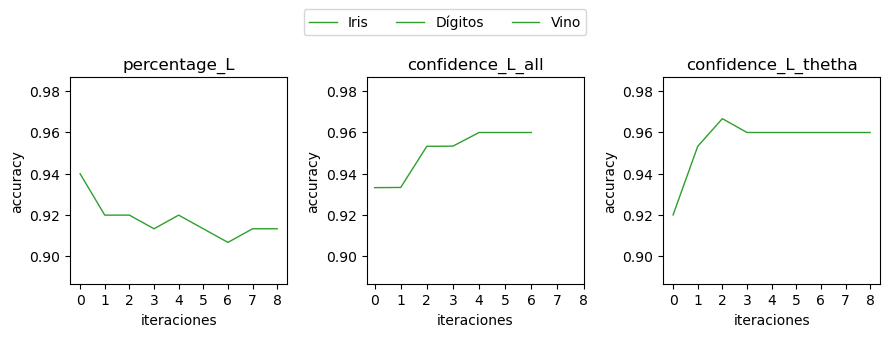

In [246]:
available = [(load_iris(return_X_y=True), 'Iris', 'B', '#2ca02c'),
                (load_digits(return_X_y=True), 'Dígitos', 'C', '#ff7f0e'),
                (load_wine(return_X_y=True), 'Vino', 'D', '#d62728'),
                (load_breast_cancer(return_X_y=True), 'Cáncer de mama', 'E', '#9467bd')]

graph_init_w_compare(available, 'CF', n_trees=6)
graph_init_w_compare(available, 'CF', n_trees=20)